## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
# Camera calibration using chessboard images
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# chessboard dimensions of black square intersections
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # print(fname, ": found corners")
        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # plt.figure()
        # plt.imshow(img)
    else:
        pass
        # print(fname, ": corners not found")


## And so on and so forth...

In [2]:
# Correcting for distortion
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# perform camera calibration, to extract distortion and transformation matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   cv2.imread('./camera_cal/calibration1.jpg').shape[1::-1],
                                                   None, None)
# perform undistortion transformation on images
# for fname in images:
#     img = cv2.imread(fname)
#     undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#     plt.figure()
#     plt.imshow(undistorted)

In [3]:
# Applying perspective transformation on chessboard images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    p = 100
    if ret:
        undist = cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        src = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        img_size = gray.shape[::-1]
        dst = np.float32([[p,p],[img_size[0]-p,p],[img_size[0]-p,img_size[1]-p],[p,img_size[1]-p]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M
    else:
        return None, None

for fname in images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_RGB2BGR)
    warped, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
#    if warped is not None:
#        plt.figure()
#        plt.imshow(img)
#        plt.figure()
#        plt.imshow(warped)
#    else:
#        print(fname, ": no success warping")

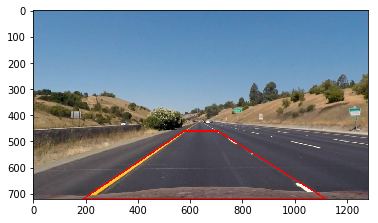

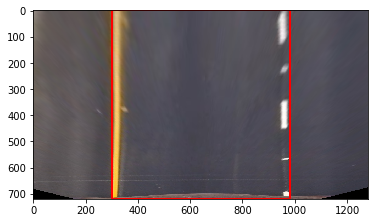

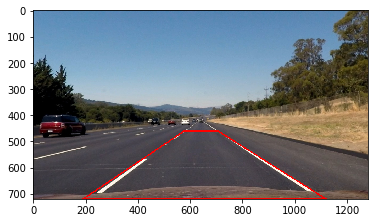

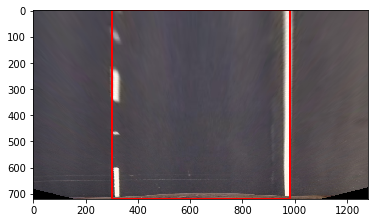

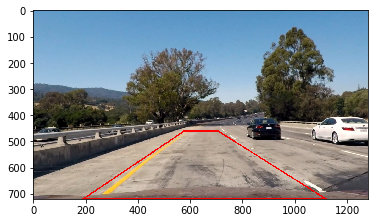

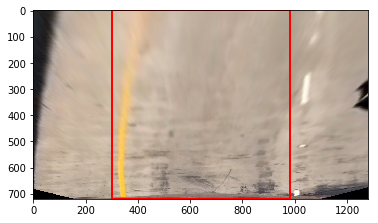

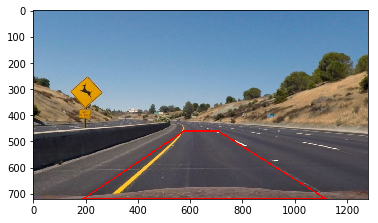

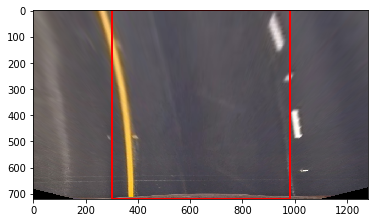

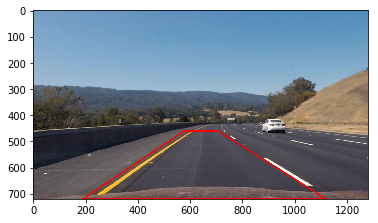

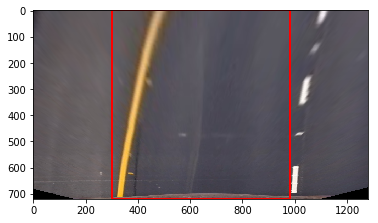

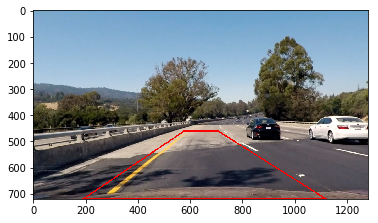

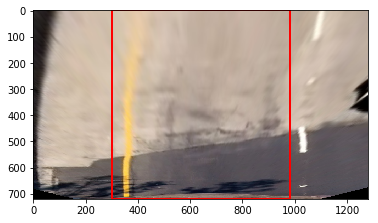

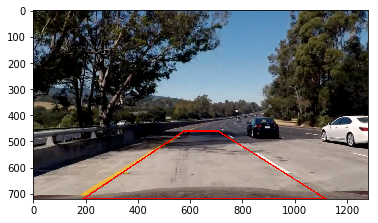

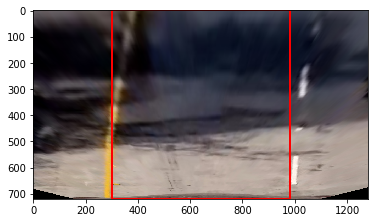

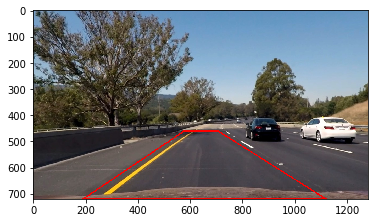

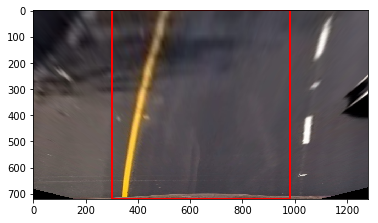

In [4]:
# Applying perspective transformation on road images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# source points: top left, top right, bottom right, bottom left
src = np.float32([[578, 460], [706, 460], [1120, 720], [190, 720]])
pts1 = np.array(src, np.int32).reshape(-1,1,2)

images = glob.glob('./test_images/*.jpg')
img_size = cv2.imread(images[0]).shape[1::-1]
p = 300
# destination points: top left, top right, bottom right, bottom left
dst = np.float32([[p,0],[img_size[0]-p,0],[img_size[0]-p,img_size[1]],[p,img_size[1]]])
pts2 = np.array(dst, np.int32).reshape(-1,1,2)

def perspective_transform(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

warped_images = []
for fname in images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_RGB2BGR)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    undist_rect = np.copy(undist)
    undist_rect = cv2.polylines(undist_rect,[pts1],True,(255, 0, 0),3)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    warped_images.append(warped)
    warped_rect = np.copy(warped)
    warped_rect = cv2.polylines(warped_rect,[pts2],True,(255, 0, 0),6)
    if warped is not None:
        plt.figure()
        plt.imshow(undist_rect)
        plt.figure()
        plt.imshow(warped_rect)
    else:
        print(fname, ": no success warping")

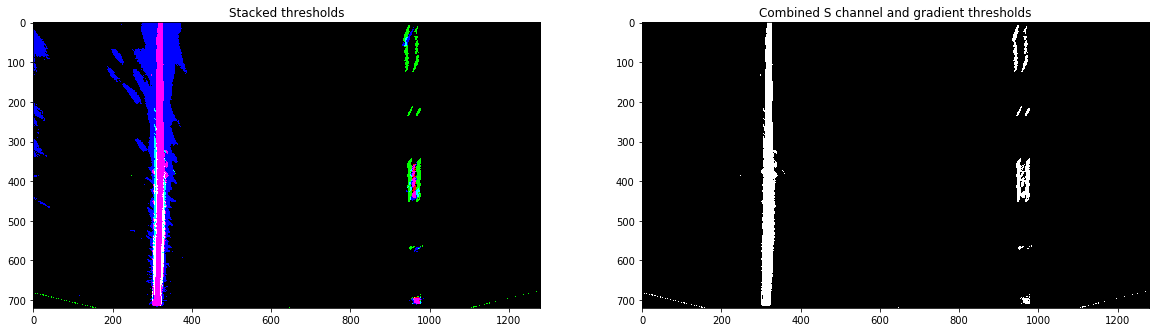

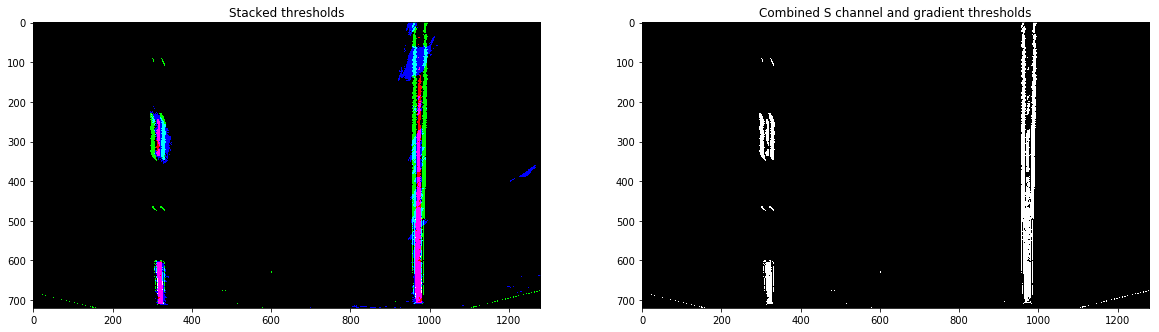

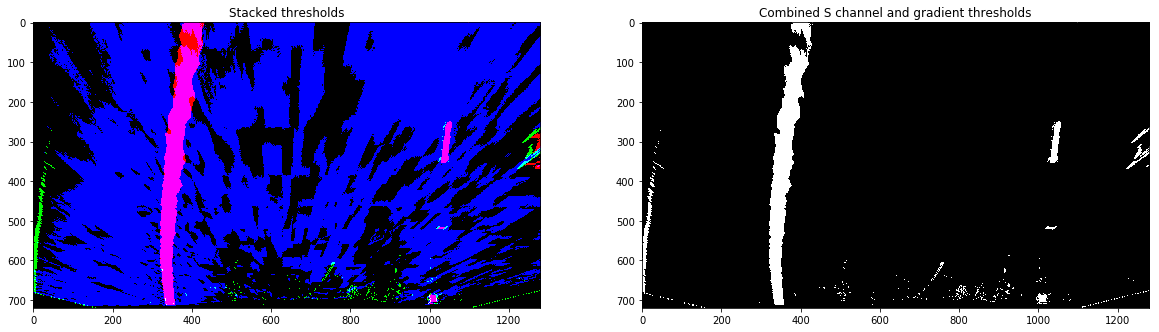

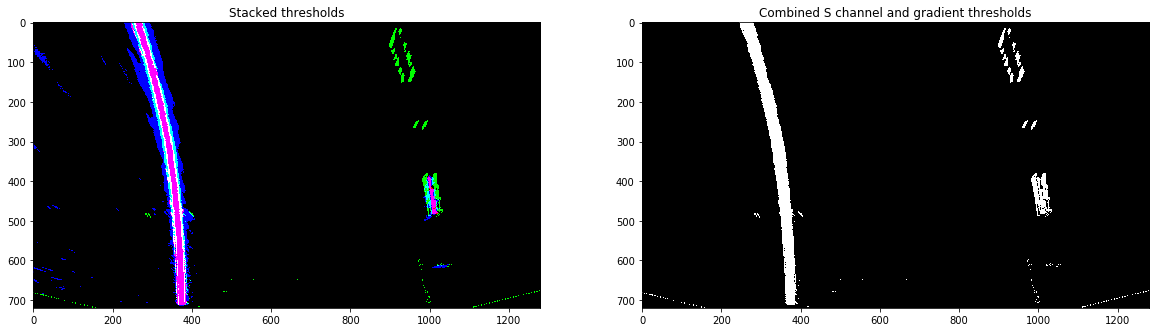

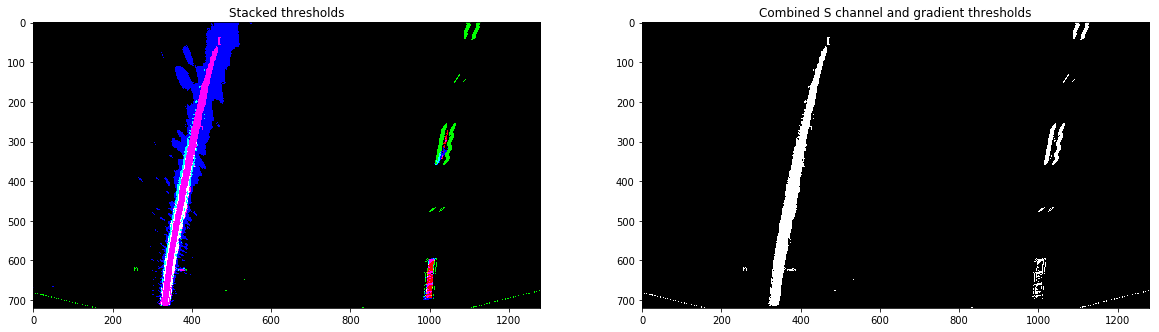

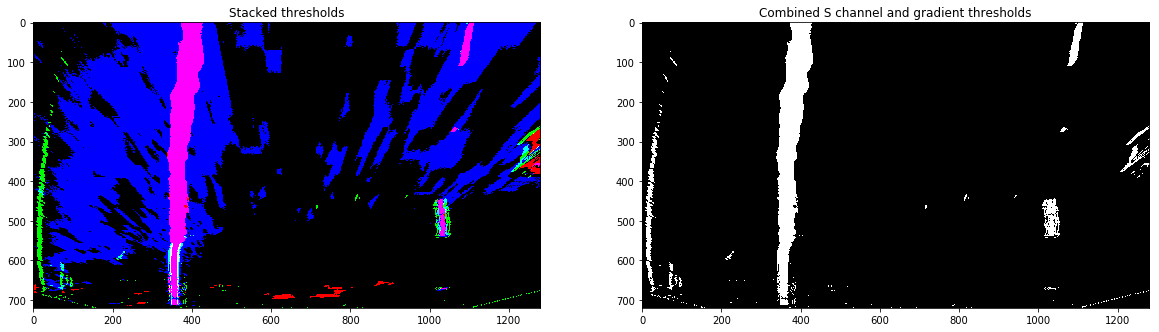

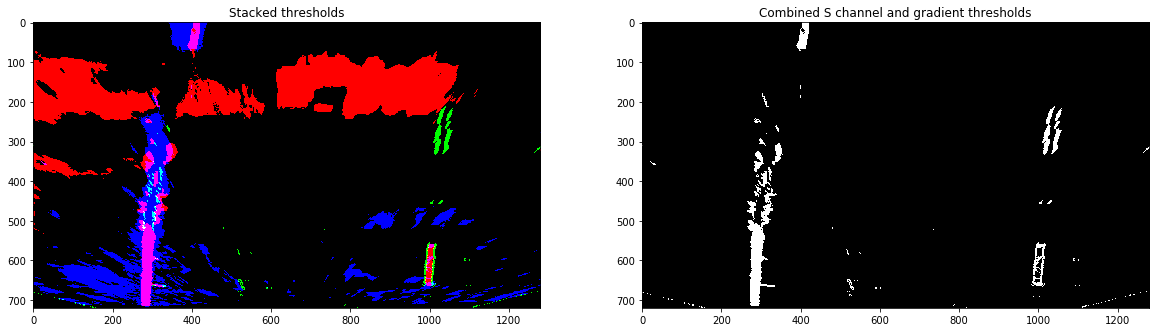

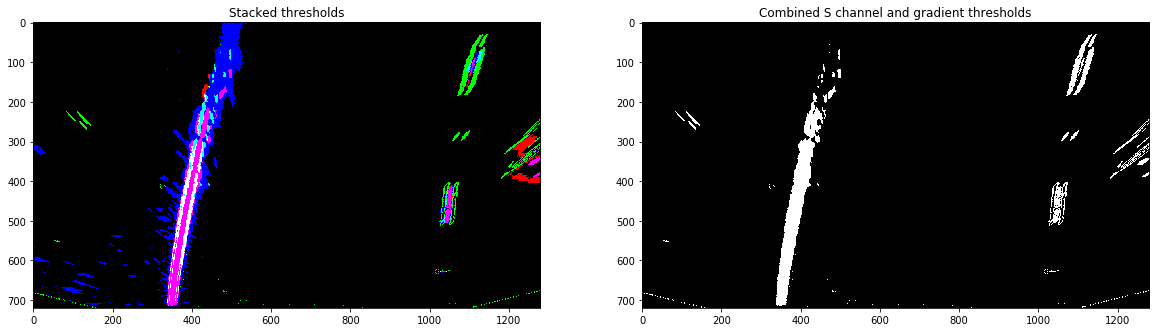

In [5]:
# Applying gradient and color channel filters to produce binary images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

images = glob.glob('./test_images/*.jpg')

def grad_n_color_filter(img):
    
    s_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,2]
    h_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:,:,0]
    # l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    
    # Threshold color channel
    h_thresh_min = 30
    h_thresh_max = 105
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel > h_thresh_min) & (h_channel <= h_thresh_max)] = 1
    s_thresh_min = 120
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    # l_thresh_min = 225
    # l_thresh_max = 255
    # l_binary = np.zeros_like(l_channel)
    # l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    # hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 35 # 20
    thresh_max = 100 # 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # s_binary = np.zeros_like(s_channel)
    # s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    color_binary = np.dstack(( s_binary, sxbinary, h_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    # combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    combined_binary[(h_binary == 1) & (s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary, color_binary

binary_warped_images = []
for img in warped_images:
    # Read in an image, you can also try test1.jpg or test4.jpg
    # img = mpimg.imread(image)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    combined_binary, color_binary = grad_n_color_filter(img)
    binary_warped_images.append(combined_binary)
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)
    
    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

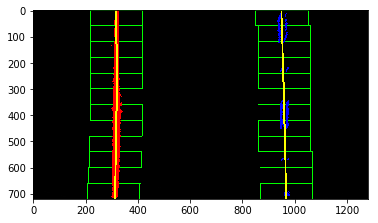

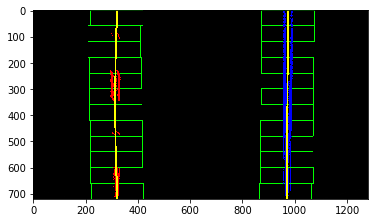

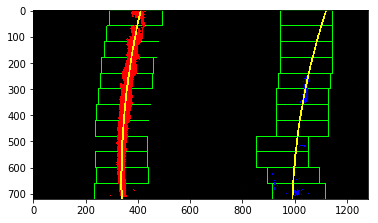

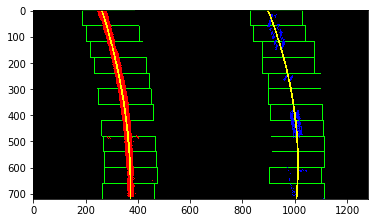

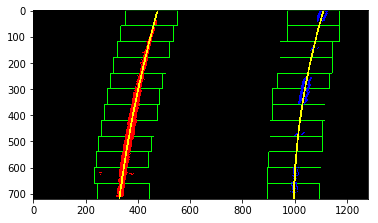

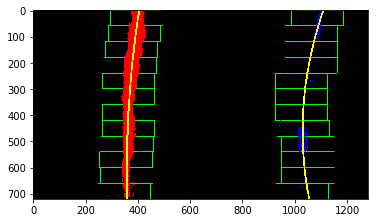

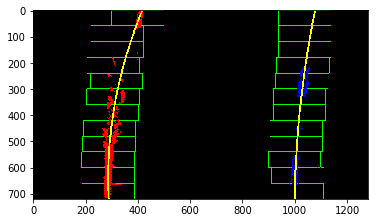

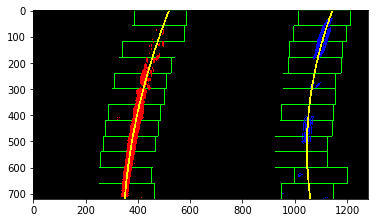

In [6]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 12
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

def find_lane_sliding_windows(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img

left_fit_values = []
right_fit_values = []
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each side
    if leftx.shape[0] == 0 or rightx.shape[0] == 0:
        return None, None, None
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        return None, None, None
    # left_fit_values.append(left_fit)
    # right_fit_values.append(right_fit)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Calc both polynomials
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    return left_fitx, right_fitx, ploty #, left_curverad, right_curverad

for img in binary_warped_images:
    plt.figure()
    leftx, lefty, rightx, righty, lane_pixels = find_lane_sliding_windows(img)
    left_fitx, right_fitx, ploty = fit_poly(lane_pixels.shape,leftx,lefty,rightx,righty)
    pts_left = np.vstack((left_fitx,ploty)).astype(np.int32).T
    pts_right = np.vstack((right_fitx,ploty)).astype(np.int32).T
    lane_pixels = cv2.polylines(lane_pixels,  [pts_left],  False,  (255, 255, 0),  5)
    lane_pixels = cv2.polylines(lane_pixels,  [pts_right],  False,  (255, 255, 0),  5)
    plt.imshow(lane_pixels)

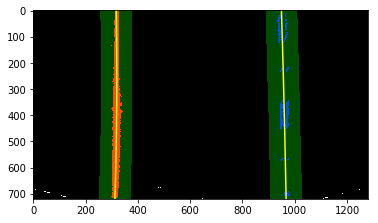

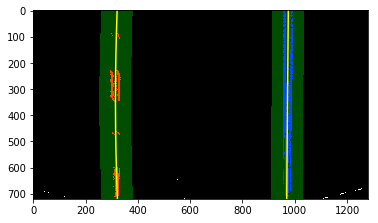

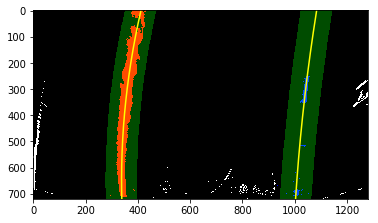

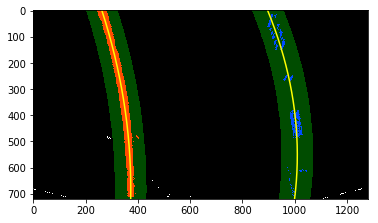

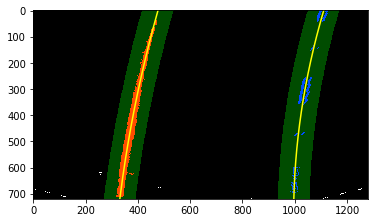

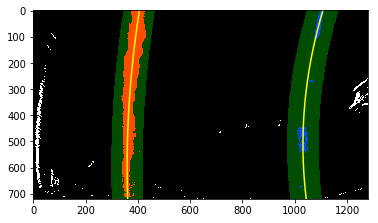

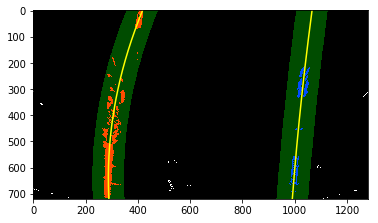

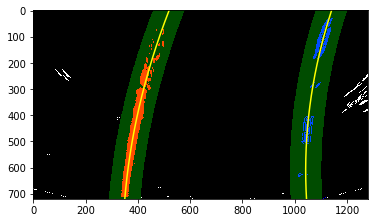

In [7]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

left_fit_values = [[-3.18299789e-05,  1.63522001e-02,  3.17425917e+02],
                   [ 5.74481755e-05, -4.03467970e-02,  3.21519649e+02],
                   [ 1.75852144e-04, -2.28166884e-01,  4.11767347e+02],
                   [-2.32006008e-04,  3.19082178e-01,  2.63141580e+02],
                   [ 1.04038287e-04, -2.78540757e-01,  4.76689708e+02],
                   [ 1.28798226e-04, -1.55382606e-01,  4.05743723e+02],
                   [ 3.18291409e-04, -4.07638400e-01,  4.17771591e+02],
                   [ 2.21829264e-04, -3.95099544e-01,  5.20323210e+02]]
right_fit_values = [[-9.28255048e-06,  3.13078001e-02,  9.49130371e+02],
                    [ 1.92515677e-06, -9.67327125e-03,  9.75268786e+02],
                    [ 2.03097485e-04, -3.25083696e-01,  1.12027456e+03],
                    [-3.32900859e-04,  3.90026618e-01,  8.97960103e+02],
                    [ 1.87173020e-04, -2.93252681e-01,  1.11050339e+03],
                    [ 3.74914034e-04, -3.45176218e-01,  1.10965151e+03],
                    [ 1.29710639e-04, -2.01956482e-01,  1.07795285e+03],
                    [ 3.52357279e-04, -3.70799481e-01,  1.14439376e+03]]
margin = 60

def find_lane_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 60

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return leftx, lefty, rightx, righty, out_img

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
for i,img in enumerate(binary_warped_images):
    plt.figure()
    leftx, lefty, rightx, righty, out_img = find_lane_around_poly(img, left_fit_values[i], right_fit_values[i])
    left_fitx, right_fitx, ploty = fit_poly(img.shape, leftx, lefty, rightx, righty)
    window_img = np.zeros_like(out_img)
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    plt.imshow(result)

In [8]:
M_inv = np.linalg.inv(M)

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def measure_curvature(ploty, x_values):
    # If no pixels were found return None
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(ploty*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

def measure_offset(img_shape, last_x_left, last_x_right):
    # compute the offset from the center
    lane_center = (last_x_left + last_x_right)/2
    offset = (lane_center - img_shape[0]/2) * xm_per_pix
    return offset

def lanes_to_road(img, left_fitx, right_fitx, ploty):
    pts_left = np.array([np.vstack((left_fitx,ploty)).astype(np.float32).T[::-1]])
    pts_right = np.array([np.vstack((right_fitx,ploty)).astype(np.float32).T])
    pts_left = cv2.perspectiveTransform(pts_left, M_inv).astype(np.int32)
    pts_right = cv2.perspectiveTransform(pts_right, M_inv).astype(np.int32)
    pts = np.hstack((pts_left, pts_right))
    lane_lines = np.zeros_like(img)
    lane_lines = cv2.fillPoly(lane_lines, [pts], (0,100, 0))
    lane_lines = cv2.polylines(lane_lines,  pts_left,  False,  (0, 255, 255),  12)
    lane_lines = cv2.polylines(lane_lines,  pts_right,  False,  (0, 255, 255),  12)
    return lane_lines

In [9]:
# Define a class to receive the characteristics of each lane detection
class Line():
    def __init__(self):
        self.detected = False  # was the line detected in the last iteration?
        self.recent_xfitted = []  # x values of the last n fits of the line
        self.bestx = None  # average x values of the fitted line over the last n iterations  
        self.best_fit = [None, None, None]  # polynomial coefficients averaged over the last n iterations
        self.current_fit = []  # polynomial coefficients for the most recent fit
        self.radius = None  # radius of curvature of the line in some units
        self.offset = None  # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float')  # difference in fit coefficients between last and new fits
        self.allx = None  # x values for detected line pixels
        self.ally = None  # y values for detected line pixels

In [10]:
Left = Line()
Right = Line()
n = 5

def process_image(img):
    warped = perspective_transform(img)
    combined_binary, color_binary = grad_n_color_filter(warped)
    if Left.detected and Right.detected:
        Left.allx, Left.ally, Right.allx, Right.ally, lane_pixels = find_lane_around_poly(combined_binary,Left.current_fit,Right.current_fit)
        if Left.allx.shape[0] >= 1000 and Right.allx.shape[0] >= 1000:
            Left.detected, Right.detected = True, True
        else:
            Left.detected, Right.detected = False, False
    if not Left.detected and not Right.detected:
        Left.allx, Left.ally, Right.allx, Right.ally, lane_pixels = find_lane_sliding_windows(combined_binary)
        if Left.allx.shape[0] >= 1000 and Right.allx.shape[0] >= 1000:
            Left.detected, Right.detected = True, True
        else:
            Left.detected, Right.detected = False, False
    if Left.detected and Right.detected:
        Left.current_fit, Right.current_fit, ploty = fit_poly(lane_pixels.shape, Left.allx, Left.ally, Right.allx, Right.ally)
        # left_fitx, right_fitx, ploty = fit_poly(lane_pixels.shape,leftx,lefty,rightx,righty)
        if len(Left.recent_xfitted) >= n and len(Right.recent_xfitted) >= n:
            Left.recent_xfitted.pop(0)
            Right.recent_xfitted.pop(0)
        Left.recent_xfitted.append(Left.current_fit)
        Right.recent_xfitted.append(Right.current_fit)
        Left.best_fit = np.average(Left.recent_xfitted, axis=0)
        Right.best_fit = np.average(Right.recent_xfitted, axis=0)
        Left.offset = round(measure_offset(lane_pixels.shape, Left.allx[-1], Right.allx[-1]),2)
    else:
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    if Left.best_fit.any() != None and Right.best_fit.any() != None:
        Left.radius = measure_curvature(ploty, Left.best_fit)
        Right.radius = measure_curvature(ploty, Right.best_fit)
        lane_lines = lanes_to_road(img, Left.best_fit, Right.best_fit, ploty)
        message1 = "Radius of curvature: {}".format(((Left.radius + Right.radius) / 2).astype(np.int32))
        message2 = "Offset from center: {}".format(Left.offset)
        out_img = cv2.addWeighted(img, 1, lane_lines, 0.6, 0)
        cv2.putText(out_img, message1, (100, 70), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
        cv2.putText(out_img, message2, (100, 140), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    else:
        out_img = img
    return out_img

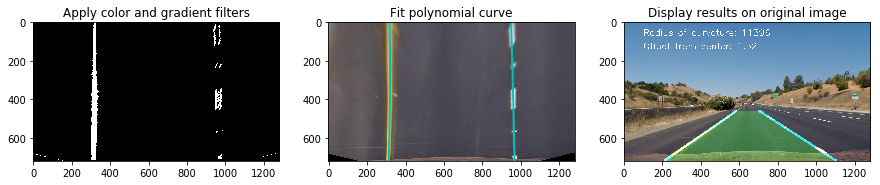

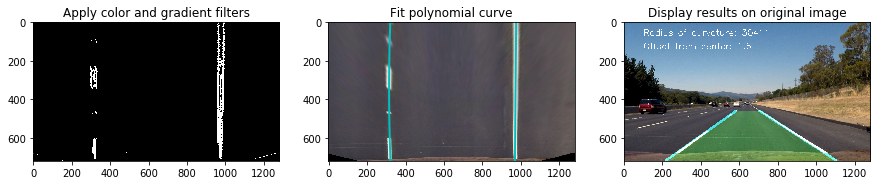

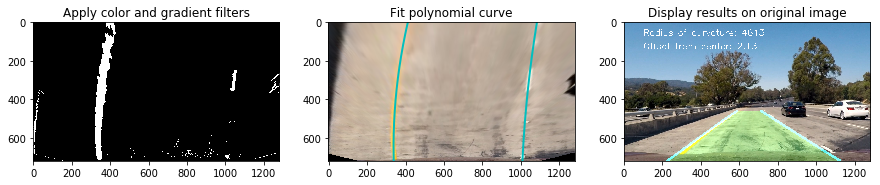

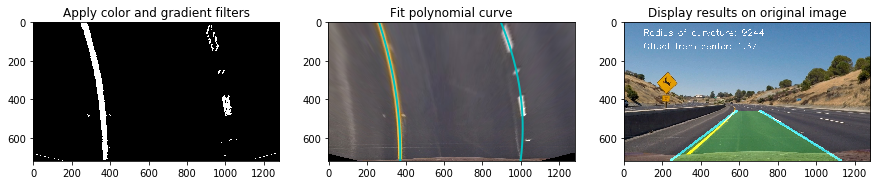

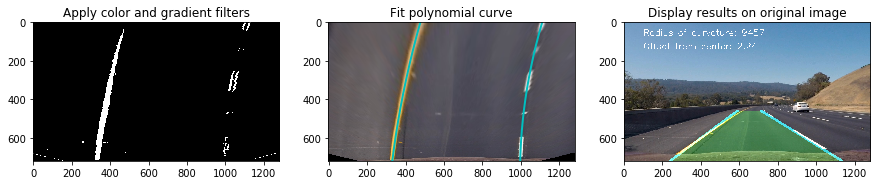

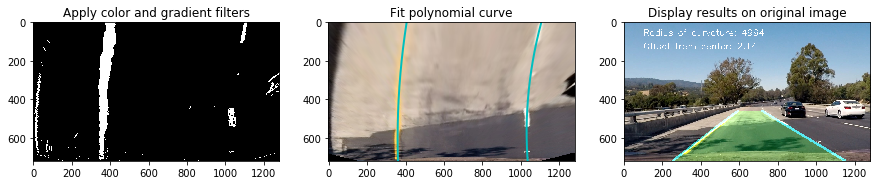

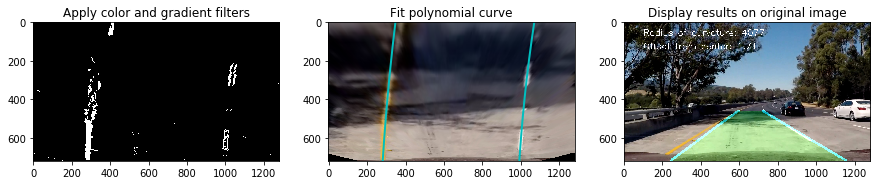

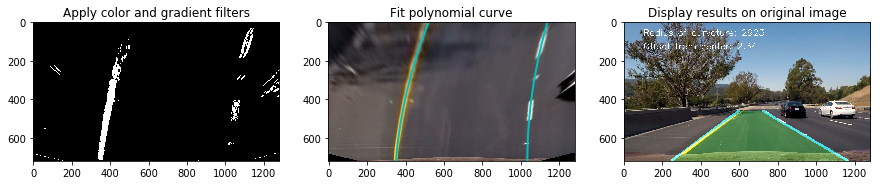

In [11]:
images = glob.glob('./test_images/*.jpg')

for fname in images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_RGB2BGR)
    f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15, 6))
    warped = perspective_transform(img)
    combined_binary, color_binary = grad_n_color_filter(warped)
    leftx, lefty, rightx, righty, lane_pixels = find_lane_sliding_windows(combined_binary)
    left_fitx, right_fitx, ploty = fit_poly(lane_pixels.shape,leftx,lefty,rightx,righty)
    
    out_img = process_image(img)
    ax1.imshow(combined_binary, cmap='gray')
    ax1.set_title('Apply color and gradient filters')
    ax2.imshow(perspective_transform(img))
    ax2.plot(left_fitx, ploty, color='c', linewidth=2)
    ax2.plot(right_fitx, ploty, color='c', linewidth=2)
    ax2.set_title('Fit polynomial curve')
    ax3.imshow(out_img)
    ax3.set_title('Display results on original image')

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Left = Line()
Right = Line()

output_video = 'output_harder_challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("harder_challenge_video.mp4")
output_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video output_harder_challenge.mp4
[MoviePy] Writing video output_harder_challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1199/1200 [03:56<00:00,  5.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_harder_challenge.mp4 

Wall time: 3min 58s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))